In [1]:
import pandas as pd
from tqdm import tqdm
import json
import os
import umap
import numpy as np
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, confusion_matrix


import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

import warnings
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import activations, initializers, constraints, regularizers
from tensorflow.keras.layers import Input, Layer, Lambda, Dropout, Reshape, Dense
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import layers, optimizers, losses, metrics, Model
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

c:\Users\oleba\Documents\git\graph-convolutional-neural-network\.venv\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\oleba\Documents\git\graph-convolutional-neural-network\.venv\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\oleba\Documen

In [2]:
edges_path = 'data/git_web_ml/musae_git_edges.csv'
targets_path = 'data/git_web_ml/musae_git_target.csv'
features_path = 'data/git_web_ml/musae_git_features.json'

In [3]:
# Read in edges
edges = pd.read_csv(edges_path)
edges.columns = ['source', 'target'] # renaming for StellarGraph compatibility

print(edges.shape)
edges.head()

(289003, 2)


,source,target
0,0,23977
1,1,34526
2,1,2370
3,1,14683
4,1,29982


In [4]:
# Read in features
with open(features_path) as json_data:
    features = json.load(json_data)
    
max_feature = np.max([v for v_list in features.values() for v in v_list])
features_matrix = np.zeros(shape = (len(list(features.keys())), max_feature+1))

i = 0
for k, vs in tqdm(features.items()):
    for v in vs:
        features_matrix[i, v] = 1
    i+=1

100%|██████████| 37700/37700 [00:00<00:00, 84339.77it/s]


In [5]:
node_features = pd.DataFrame(features_matrix, index = features.keys())
print(node_features.shape)
node_features.head()

(37700, 4005)


,0,1,2,3,4,5,6,7,8,9,...,3995,3996,3997,3998,3999,4000,4001,4002,4003,4004
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Read in targets
targets = pd.read_csv(targets_path)
targets.index = targets.id.astype(str)
targets = targets.loc[features.keys(), :]
print(targets.shape)
targets.head()


(37700, 3)


,id,name,ml_target
id,,,
0,0,Eiryyy,0
1,1,shawflying,0
2,2,JpMCarrilho,1
3,3,SuhwanCha,0
4,4,sunilangadi2,1


In [7]:
targets.ml_target.value_counts(normalize=True)

ml_target
0    0.741671
1    0.258329
Name: proportion, dtype: float64

In [8]:
G = sg.StellarGraph(node_features, edges.astype(str))
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 37700, Edges: 289003

 Node types:
  default: [37700]
    Features: float32 vector, length 4005
    Edge types: default-default->default

 Edge types:
    default-default->default: [289003]
        Weights: all 1 (default)
        Features: none


In [9]:
train_pages, test_pages = train_test_split(targets, train_size=50)
val_pages, test_pages = train_test_split(test_pages, train_size=50)
train_pages.shape, val_pages.shape, test_pages.shape

((50, 3), (50, 3), (37600, 3))

In [10]:
target_encoding = LabelBinarizer()

train_targets = target_encoding.fit_transform(train_pages['ml_target'])
val_targets = target_encoding.transform(val_pages['ml_target'])
test_targets = target_encoding.transform(test_pages['ml_target'])

In [11]:
# Get the adjacency matrix
A = G.to_adjacency_matrix(weighted=False)

# Add self-connections
A_t = A + sp.diags(np.ones(A.shape[0]) - A.diagonal())

# Degree matrix to the power of -1/2
D_t = sp.diags(np.power(np.array(A.sum(1)), -0.5).flatten(), 0)

# Normalise the Adjacency matrix
A_norm = A.dot(D_t).transpose().dot(D_t).todense()

In [12]:
# Define the function to get these indices
def get_node_indices(G, ids):
    # find the indices of the nodes
    node_ids = np.asarray(ids)
    flat_node_ids = node_ids.reshape(-1)

    flat_node_indices = G.node_ids_to_ilocs(flat_node_ids) # convert to indices
    # back to the original shape
    node_indices = flat_node_indices.reshape(1, len(node_ids)) # add 1 extra dimension
    
    return node_indices

train_indices = get_node_indices(G, train_pages.index)
val_indices = get_node_indices(G, val_pages.index)
test_indices = get_node_indices(G, test_pages.index)

In [13]:
# Expand dimensions
features_input = np.expand_dims(features_matrix, 0)
A_input = np.expand_dims(A_norm, 0)

y_train = np.expand_dims(train_targets, 0)
y_val = np.expand_dims(val_targets, 0)
y_test = np.expand_dims(test_targets, 0)

In [14]:
from stellargraph.layer.gcn import GraphConvolution, GatherIndices
# Initialise GCN parameters
kernel_initializer="glorot_uniform"
bias = True
bias_initializer="zeros"
n_layers = 2
layer_sizes = [32, 32]
dropout = 0.5
n_features = features_input.shape[2]
n_nodes = features_input.shape[1]

In [15]:
# Input layers
x_features = Input(batch_shape=(1, n_nodes, n_features))
x_indices = Input(batch_shape=(1, None), dtype="int32")
x_adjacency = Input(batch_shape=(1, n_nodes, n_nodes))
x_inp = [x_features, x_indices, x_adjacency]
x_inp

[<KerasTensor: shape=(1, 37700, 4005) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(1, None) dtype=int32 (created by layer 'input_2')>,
 <KerasTensor: shape=(1, 37700, 37700) dtype=float32 (created by layer 'input_3')>]

In [16]:
x = Dropout(0.5)(x_features)
x = GraphConvolution(32, activation='relu', 
                     use_bias=True,
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer)([x, x_adjacency])
x = Dropout(0.5)(x)
x = GraphConvolution(32, activation='relu', 
                     use_bias=True,
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer)([x, x_adjacency])

x = GatherIndices(batch_dims=1)([x, x_indices])
output = Dense(1, activation='sigmoid')(x)

In [17]:
model = Model(inputs=[x_features, x_indices, x_adjacency], outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(1, 37700, 4005)]   0           []                               
                                                                                                  
 dropout (Dropout)              (1, 37700, 4005)     0           ['input_1[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(1, 37700, 37700)]  0           []                               
                                                                                                  
 graph_convolution (GraphConvol  (1, 37700, 32)      128192      ['dropout[0][0]',                
 ution)                                                           'input_3[0][0]']            

In [18]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.binary_crossentropy,
    metrics=["acc"],
)
es_callback = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

In [19]:
history = model.fit(
    x = [features_input, train_indices, A_input],
    y = y_train,
    batch_size = 32,
    epochs=20,
    validation_data=([features_input, val_indices, A_input], y_val),
    verbose=1,
    shuffle=False,
    callbacks=[es_callback],
)

Epoch 1/20
1/1 [==============================] - 272s 272s/step - loss: 0.6931 - acc: 0.6800 - val_loss: 0.5990 - val_acc: 0.8200
Epoch 2/20
1/1 [==============================] - 64s 64s/step - loss: 0.6109 - acc: 0.8000 - val_loss: 0.5083 - val_acc: 0.8200
Epoch 3/20
1/1 [==============================] - 66s 66s/step - loss: 0.5272 - acc: 0.8000 - val_loss: 0.4513 - val_acc: 0.8200
Epoch 4/20
1/1 [==============================] - 66s 66s/step - loss: 0.4608 - acc: 0.8000 - val_loss: 0.4436 - val_acc: 0.8200
Epoch 5/20
1/1 [==============================] - 69s 69s/step - loss: 0.4603 - acc: 0.8000 - val_loss: 0.4636 - val_acc: 0.8200
Epoch 6/20
1/1 [==============================] - 66s 66s/step - loss: 0.4535 - acc: 0.8000 - val_loss: 0.4779 - val_acc: 0.8200
Epoch 7/20
1/1 [==============================] - 65s 65s/step - loss: 0.5068 - acc: 0.8000 - val_loss: 0.4706 - val_acc: 0.8200
Epoch 8/20
1/1 [==============================] - 69s 69s/step - loss: 0.4651 - acc: 0.8000 - v

ResourceExhaustedError: Graph execution error:

OOM when allocating tensor with shape[1,37700,37700] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node GatherV2_2}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1688]

In [20]:
# Model evaluation
test_preds = model.predict([features_input, test_indices, A_input])
def evaluate_preds(true, pred):
    auc = roc_auc_score(true, pred)
    pr = average_precision_score(true, pred)
    bin_pred = [1 if p > 0.5 else 0 for p in pred]
    f_score = f1_score(true, bin_pred)
    print('ROC AUC:', auc)
    print('PR AUC:', pr)
    print('F1 score:', f_score)
    print(confusion_matrix(true, bin_pred, normalize='true'))
    
    return auc, pr, f_score

1/1 [==============================] - 46s 46s/step


In [21]:
auc, pr, f_score = evaluate_preds(test_targets.ravel(),test_preds[0].ravel())

ROC AUC: 0.6944985582685348
PR AUC: 0.4353895767726747
F1 score: 0.0
[[1. 0.]
 [1. 0.]]


In [22]:
embedding_model = Model(inputs=x_inp, outputs=model.layers[-2].output)
all_indices = get_node_indices(G, targets.index)
emb = embedding_model.predict([features_input, all_indices, A_input])
emb.shape

1/1 [==============================] - 37s 37s/step


(1, 37700, 32)

In [31]:
u = umap.UMAP(random_state=3456346)
umap_embs = u.fit_transform(emb[0])

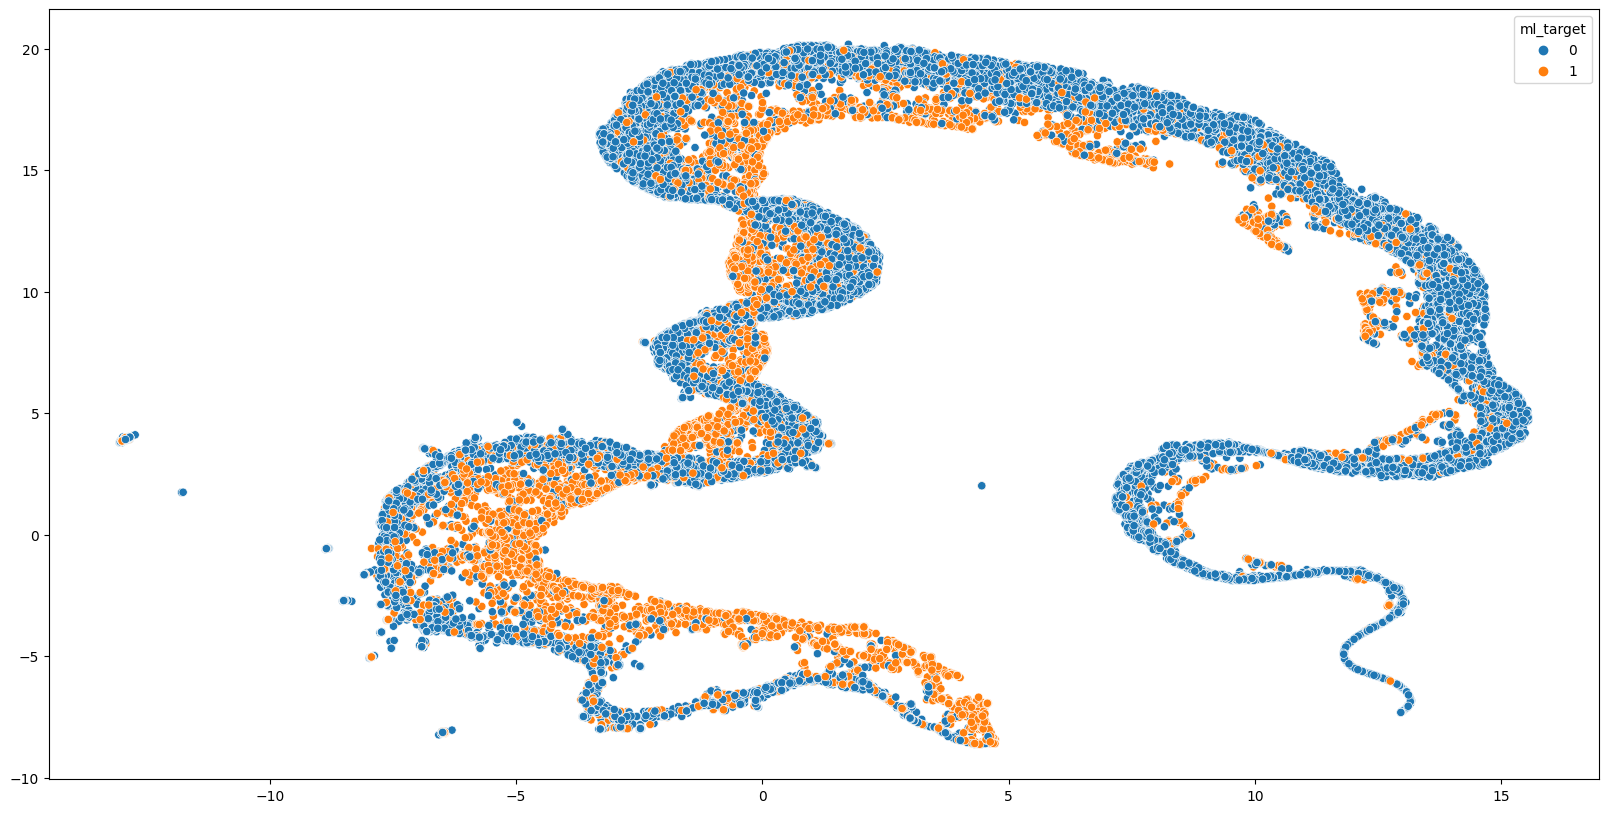

In [32]:
plt.figure(figsize=(20,10))
ax = sns.scatterplot(x = umap_embs[:, 0], y = umap_embs[:, 1], hue = targets['ml_target'])
# save the figure
plt.savefig('umap.png', dpi=300, bbox_inches='tight')